# Predicting Subtypes: Ensembled Regularlized Regression


In this notebook, we will load the data and start an ensemble of regression models to predict LPS values (Linear Predictive Score) from NanoString Lymph2Cx assay using the genomic features detected in the training/test set.

In [58]:
import pandas as pd
import numpy as np
import random
from scipy.stats import gaussian_kde

from sklearn.base import BaseEstimator, TransformerMixin # To build transformer for sklearn pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    precision_recall_curve,
    auc,
    average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns


coo_colors = {'GCB': '#EFB06C', 'ABC': '#86B6DF', 'Unclassified': '#94C89C'}

gcb_threshold = 1960

## Train/Test + Validation splits

- Samples in the metadata are split into `Train`/`Pilot`/`Test` groups. 
- `Test` group  (n=80) is our Validation set.
- We will use all other samples for model building

In [2]:
# Loading the metadata
goya_metadata = pd.read_excel("https://ehsantabari.com/public/goya_paper/Supplementary_Table_1.xlsx") 

# There is a space after the sample number column name: Fix it
goya_metadata.rename(columns={"Sample number ": "Sample number"}, inplace=True)

# make sure samples are sorted by their ID
goya_metadata.sort_values("Sample number", inplace=True)

goya_metadata.groupby("Group").size()

Group
Pilot           30
Test            80
Train (high)    80
Train (low)     80
Train (mid)     40
dtype: int64

In [3]:
validation_samples = goya_metadata[goya_metadata["Group"] == "Test"]


modeling_samples = goya_metadata[goya_metadata["Group"] != "Test"]
modeling_samples

,Sample number,Ann Arbor stage,NanoString,LPS score,FMI data available,Group,Treatment arm,ECOG PS,IPI score,Serum LDH,Bulky disease,Extracted mass (ng cfDNA),Plasma volume (mL),Input mass (ng cfDNA),Median deduped depth,Mean AF,Median AF,MAD,MATH,Corrected MMPM
0,1,III,GCB,917,True,Train (low),Obinutuzumab,0.0,High-Intermediate,Elevated,N,55.965,2.5,40.93,6774,0.004182,0.001173,0.000773,65.916953,30.891147
1,2,III,GCB,1176,True,Train (low),Rituximab,1.0,Low-Intermediate,Elevated,N,119.600,2.5,29.48,7115,0.054369,0.017381,0.024814,142.761107,858.328860
2,3,III,ABC,3025,True,Train (high),Obinutuzumab,0.0,Low-Intermediate,Elevated,N,146.900,2.5,50.00,6707,0.103586,0.079399,0.113012,142.333867,2008.620414
3,4,IV,GCB,1087,True,Train (low),Obinutuzumab,1.0,Low-Intermediate,Elevated,N,24.245,2.2,50.00,7866,0.024643,0.020713,0.017275,83.403532,89.621889
6,7,III,GCB,761,True,Train (low),Rituximab,2.0,High-Intermediate,Normal,N,64.545,1.3,50.00,8118,0.044407,0.023519,0.032789,139.412568,727.584726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,305,III,Unclassified,2265,True,Train (mid),Obinutuzumab,1.0,Low-Intermediate,Normal,N,30.160,2.4,23.20,5103,0.029804,0.024483,0.029227,119.375961,123.598901
306,307,III,GCB,-432,True,Pilot,Obinutuzumab,1.0,Low,Normal,N,10.800,2.5,8.76,909,0.248875,0.200238,0.271518,135.597595,354.795908
307,308,IV,GCB,947,True,Train (low),Rituximab,0.0,High-Intermediate,Elevated,N,40.560,2.0,31.20,6005,0.050138,0.029006,0.035903,123.775503,335.541944
308,309,II,ABC,3172,True,Train (high),Rituximab,0.0,High-Intermediate,Elevated,N,37.050,2.0,28.50,4087,0.014858,0.008621,0.007674,89.016607,90.831088


## Data in the Train/Test + Validation

Loading the `gene_noAf` data, and separating the modeling and validation 

In [4]:
goya_data = pd.read_csv("goya_data-gene_noAf-25_03_08_08_14.csv")

goya_data_modeling = goya_data[goya_data["Sample number"].isin(modeling_samples["Sample number"])]
goya_data_validation = goya_data[goya_data["Sample number"].isin(validation_samples["Sample number"])]


goya_data_modeling

,Sample number,ABCB11_SNV,AC004623.2_SNV,AC007250.4_SNV,AC007386.4_SNV,AC0142.1_SNV,AC092170.1-AC009312.1_SNV,AC096579.13_SNV,AC118562.1-RP11-427M20.1_SNV,AC245028.1_SNV,...,TSPOAP1-AS1_INDEL,XBP1_INDEL,ZEB2_INDEL,ZFP36L1_INDEL,ZFP42_INDEL,ZNF608_INDEL,ZNF649_INDEL,BCL2_SV,BCL6_SV,MYC_SV
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,305,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,307,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307,308,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
308,309,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Parameter tuning with Cross Validation

I will leave 20% of the modeling dataset for checking the modeling.

In [5]:
# 1. Set up the Validation set
#    - "LPS Score" is taken as the numeric target (y)
X_val = goya_data_validation.drop(columns=["Sample number"])  # drop non-feature columns
y_val = validation_samples["LPS score"]

# 2. Define modeling set as our X
#    - "LPS Score" is taken as the numeric target (y)
X = goya_data_modeling.drop(columns=["Sample number"])  # drop non-feature columns
y = modeling_samples["LPS score"]


# Split the modeling set into train and test to get an unbiased modeling evaluation
# X_train will be used for cross-validation and hyperparameter tuning
# X_test will be used for the evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape
# At the end, X (X_train + X_test) will be used for the final model training

(184, 674)

### Building the Ensemble #1 - Quick and Easy

Here I just run 500 models, each of them get a subset of features 


In [ ]:
## This took ~5.2 mins to run on MacBook Air M1
n_models = 500
fraction_of_features = 0.75
all_preds = []
all_chosen_features = []
all_model_params = []

# Hyperparameter space for ElasticNet
param_grid = {
    "alpha": [0.1, 1.0, 10.0, 30, 100.0],
    "l1_ratio": [0.5, 0.9, .95, .99, .995]
}

_rng = random.Random(42)

for i in range(n_models):
    # Randomly select a subset of columns (you can fix subset size if you wish)
    subset_size = int(X.shape[1] * fraction_of_features)
    chosen_features = _rng.sample(X_train.columns.to_list(), subset_size)
    all_chosen_features.append(chosen_features)

    # Prepare data subset
    X_train_subset = X_train[chosen_features]
    X_test_subset  = X_test[chosen_features]

    # Hyperparameter tuning with cross validation
    en_model = ElasticNet(random_state=42, max_iter=100000)
    grid_search = GridSearchCV(
        estimator=en_model,
        param_grid=param_grid,
        cv=5,             # 5-fold cross validation
        scoring="neg_mean_squared_error",
        n_jobs=-1        # use multiple cores if available
    )
    grid_search.fit(X_train_subset, y_train)

    # Train final model using best hyperparams on entire training set
    best_en_model = grid_search.best_estimator_
    all_model_params.append(grid_search.best_params_)

    # Predict on test subset
    preds = best_en_model.predict(X_test_subset)
    all_preds.append(preds)



In [10]:
(
    set([a["alpha"] for a in all_model_params]),
    set([a["l1_ratio"] for a in all_model_params]),
)

({1.0, 10.0}, {0.9, 0.99, 0.995})

### Building the Ensemble #2 - Professional

This way, I make this into a much well organized structure



#### Build Transformer that select a subset of feature space

First I built a transformer class that can be passed through a pipline and subsets the columns

In [12]:
# custom RandomFeatureSubset transformer that randomly selects
# a fraction (e.g., 80%) of the input features at fit time,
#  and uses the same subset during transform:
class RandomFeatureSubset(BaseEstimator, TransformerMixin):
    def __init__(self, fraction=0.8, random_state=None):
        self.fraction = fraction
        self.random_state = random_state

    def fit(self, X, y=None):
        self._rng = random.Random(self.random_state)
        subset_size = int(X.shape[1] * self.fraction)

        if isinstance(X, pd.DataFrame):
            all_columns = X.columns.to_list()
            self.selected_features_ = self._rng.sample(all_columns, subset_size)
        else:
            self.selected_features_ = self._rng.choice(
                X.shape[1], size=subset_size, replace=False
            )

        # Choose subset of features without replacement
        return self

    def transform(self, X, y=None):
        # Use the selected feature indices
        return X.loc[:, self.selected_features_]
    

### Test the transformer
print("Test 1: randoms state 13")
print(RandomFeatureSubset(fraction=0.01, random_state=13).fit(X_train).selected_features_)
print(RandomFeatureSubset(fraction=0.01, random_state=13).fit(X_test).selected_features_)

print("Test 2: randoms state 42")
print(RandomFeatureSubset(fraction=0.01, random_state=42).fit(X_train).selected_features_)
print(RandomFeatureSubset(fraction=0.01, random_state=42).fit(X_test).selected_features_)

Test 1: randoms state 13
['IRF4_SNV', 'LRP1B_SNV', 'IGHV1-24_SNV', 'ZFP36L1_INDEL', 'IGLJ7-IGLC7_SNV', 'HIST1H2BD_SNV']
['IRF4_SNV', 'LRP1B_SNV', 'IGHV1-24_SNV', 'ZFP36L1_INDEL', 'IGLJ7-IGLC7_SNV', 'HIST1H2BD_SNV']
Test 2: randoms state 42
['SRRM2_INDEL', 'ELK2BP-IGHA2_SNV', 'ARHGAP5_SNV', 'KLK11_SNV', 'IGLV3-21_SNV', 'IGLC4_SNV']
['SRRM2_INDEL', 'ELK2BP-IGHA2_SNV', 'ARHGAP5_SNV', 'KLK11_SNV', 'IGLV3-21_SNV', 'IGLC4_SNV']


In [13]:
## Test to see if it works in a pipeline:

pipeline = Pipeline([
    ('random_feature_subset', RandomFeatureSubset(fraction=0.05, random_state=42)),
    ('classifier', ElasticNet(max_iter=100000, random_state=42))
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

## No errors mean that the same columns are selected for both train and test
print("Pipeline test passed")

Pipeline test passed


#### Build The Ensemble model 

(How things could fail for GridSearchCV)

The ensemble built here is a votingregressor of a set of ElasticNet models

- Each model is trained independantly
  - They get a subset of features as input
  - each model gets its own hyper-parameters

In [14]:
n_models = 100
models = []

for i in range(n_models):
    pipeline = Pipeline(
        [
            (
                "random_feature_subset",
                RandomFeatureSubset(fraction=0.8, random_state=i),
            ),
            ("classifier", ElasticNet(max_iter=100000, random_state=i)),
        ]
    )
    models.append(pipeline)

ensemble_elasticnet = VotingRegressor(
    estimators=[(f"model_{i}", model) for i, model in enumerate(models)]
)

#### Set up Grid Search for the Ensemble

In [15]:
## THIS WILL FAIL:
param_grid = {}
for i in range(n_models):
    param_grid[f"estimators__model_{i}__classifier__alpha"] = [1, 10, 100]
    param_grid[f"estimators__model_{i}__classifier__l1_ratio"] = [0.9, 0.95, 0.99]



grid_search = GridSearchCV(
    estimator=ensemble_elasticnet,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # or whatever scoring you prefer
    cv=5,
    n_jobs=-1
)

# for each of 100 sub‐models, 
# GridSearchCV takes the Cartesian product of all parameter lists across all sub‐estimators. 
# With 3 values of α and 3 values of l1_ratio per model, 
# that’s 3×3=9 combinations for one model—but for 100 models, 
# it attempts 9^100 total combinations (which is absurdly huge). 
# Simply enumerating that space is impossible, hence the overflow.

grid_search.fit(X_train, y_train)

OverflowError: cannot fit 'int' into an index-sized integer

## Build a Final model and Validate

Now I will use the same L1 preferred regularization that I have been seeing in single ElasticNet and above runs. 


In [ ]:
n_models = 500
models = []

for i in range(n_models):
    pipeline = Pipeline(
        [
            (
                "random_feature_subset",
                RandomFeatureSubset(fraction=0.8, random_state=i),
            ),
            (
                "classifier",
                ElasticNet(max_iter=100000, alpha=10, l1_ratio=0.99, random_state=i),
            ),
        ]
    )
    models.append(pipeline)

ensemble_elasticnet = VotingRegressor(
    estimators=[(f"model_{i}", model) for i, model in enumerate(models)]
)

In [ ]:
ensemble_elasticnet.fit(X, y)
y_pred_val = ensemble_elasticnet.predict(X_val)

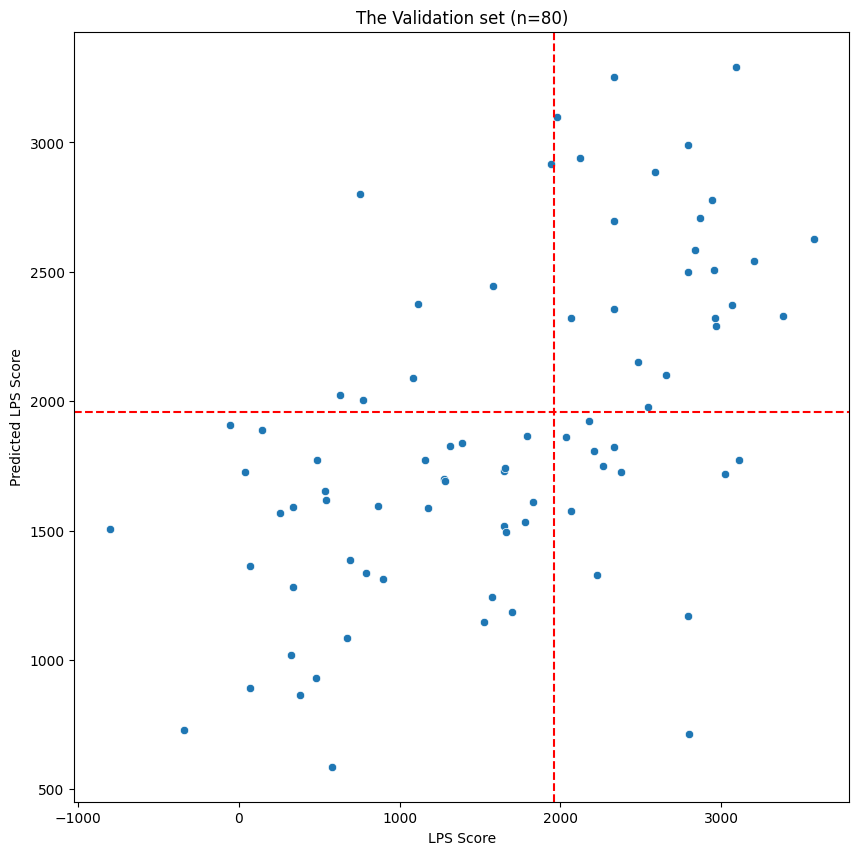

In [19]:
plt.figure(figsize=(10, 10))


p = sns.scatterplot(x=y_val, y= y_pred_val)
p.set(xlabel="LPS Score", ylabel="Predicted LPS Score", title="The Validation set (n=80)")
plt.axhline(1960, color="red", linestyle="--")
plt.axvline(1960, color="red", linestyle="--")

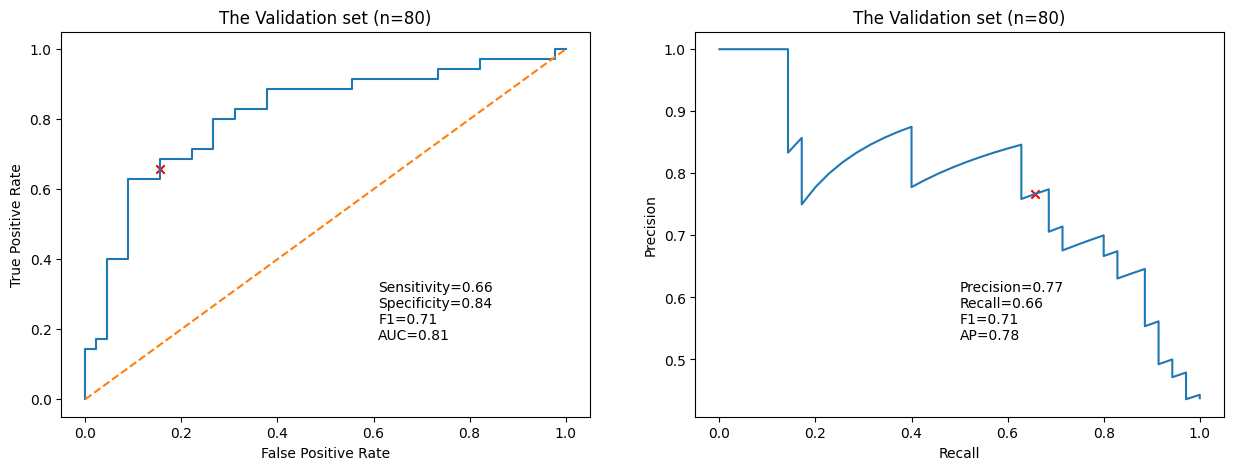

In [ ]:
## ABC (non-GCB) samples are above the threshold (positive class)
y_val_class = (y_val >= gcb_threshold).astype(int)
y_pred_val_class = (y_pred_val >= gcb_threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y_val_class, y_pred_val_class)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

precision = precision_score(y_val_class, y_pred_val_class)
recall = recall_score(y_val_class, y_pred_val_class)
f1 = f1_score(y_val_class, y_pred_val_class)

# ROC and AUC
# For ROC, we should use the raw prediction values (or probabilities in classification models).
# Here, using continuous predictions from ElasticNet:
fpr, tpr, _ = roc_curve(y_val_class, y_pred_val)
roc_auc = auc(fpr, tpr)


# Precision-Recall curve
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(
    y_val_class, y_pred_val
)
pr_auc = average_precision_score(y_val_class, y_pred_val)

# Plot 1: ROC
fig1, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
ax[0].scatter(fp / (fp + tn), tp / (tp + fn), color="red", marker="x")
ax[0].plot([0, 1], [0, 1], linestyle="--")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("The Validation set (n=80)")
ax[0].text(
    0.6,
    0.2,
    f"Sensitivity={recall:.2f}\nSpecificity={specificity:.2f}\nF1={f1:.2f}\nAUC={roc_auc:.2f}",
    transform=ax[0].transAxes,
)

# Plot 2: Precision-Recall
ax[1].plot(recall_vals, precision_vals, label=f"AP = {pr_auc:.2f}")
ax[1].scatter(tp / (tp + fn), tp / (tp + fp), color="red", marker="x")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("The Validation set (n=80)")
ax[1].text(
    0.5,
    0.2,
    f"Precision={precision:.2f}\nRecall={recall:.2f}\nF1={f1:.2f}\nAP={pr_auc:.2f}",
    transform=ax[1].transAxes,
)
plt.show()

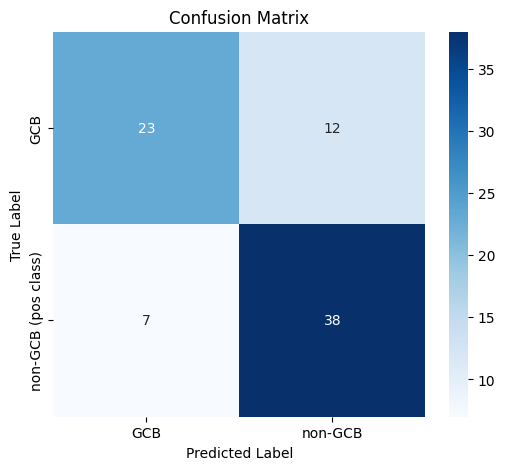

In [118]:
plt.figure(figsize=(6, 5))
p = sns.heatmap(
    cm[::-1, ::-1],
    annot=True,
    fmt="d",
    cmap="Blues",
    yticklabels=['GCB', 'non-GCB (pos class)'],
    xticklabels=['GCB', 'non-GCB'],
)
_ = p.set(xlabel="Predicted Label", ylabel="True Label", title="Confusion Matrix")

We are overcalling non-GCB: 

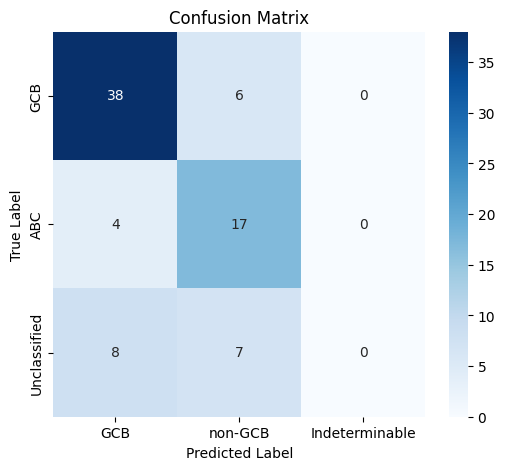

In [120]:
plt.figure(figsize=(6, 5))
p = sns.heatmap(
    # Make a confusion matrix against the NanoString classification
    confusion_matrix(
        pd.Categorical(
            validation_samples["NanoString"], categories=["GCB", "ABC", "Unclassified"]
        ).codes,
        y_pred_val_class,
    ),
    annot=True,
    fmt="d",
    cmap="Blues",
    yticklabels=["GCB", "ABC", "Unclassified"],
    xticklabels=["GCB", "non-GCB", "Indeterminable"],
)
_ = p.set(xlabel="Predicted Label", ylabel="True Label", title="Confusion Matrix")

#### Individial Model Predictions

In [61]:
## Get the predictions of each sub-model
all_preds = []
for _, est in enumerate(ensemble_elasticnet.estimators_):
    # `est` will be the fitted Pipeline in this case
    preds = est.predict(X_val)
    all_preds.append(preds)

all_preds = np.array(all_preds).T

In [65]:
## Check if the avreage of submodel predictions match the Ensemble predictions

np.all(np.mean(all_preds, axis=1) == y_pred_val)

np.True_

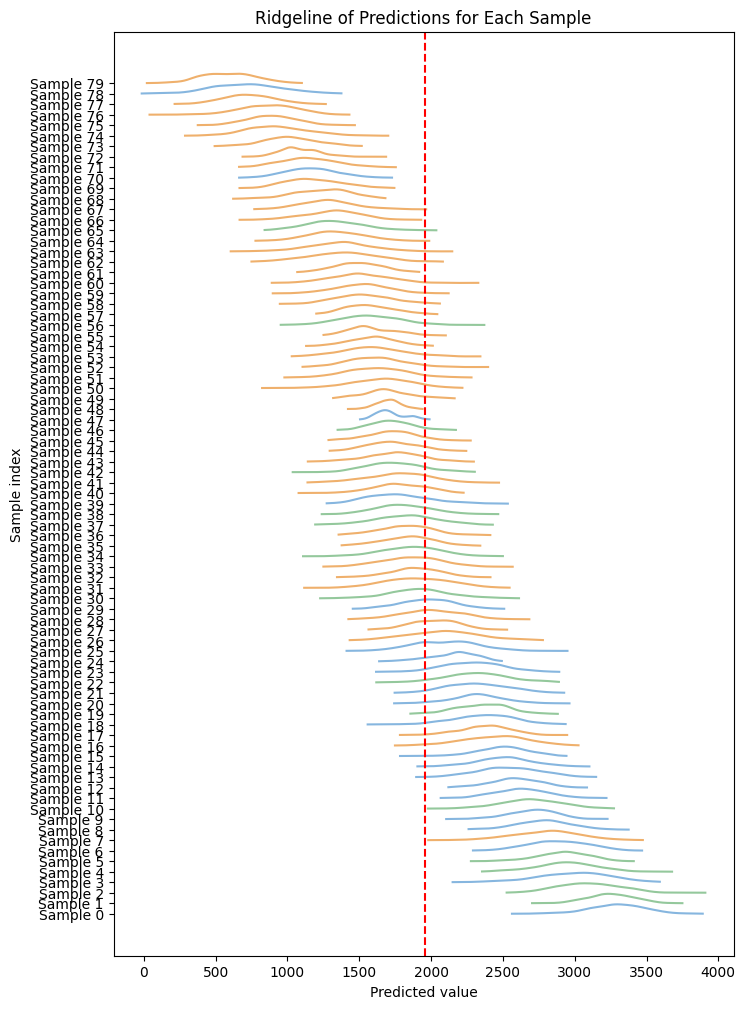

In [62]:
plt.figure(figsize=(8, 12))

ridge_scale=0.9

n_samples = all_preds.shape[0]

sorted_indices = np.argsort(np.mean(all_preds, axis=1))

for rank, sample_idx in enumerate(sorted_indices[::-1]):
    sample_predictions = all_preds[sample_idx]

    # Compute the x values for plotting density
    x_range = np.linspace(sample_predictions.min(), sample_predictions.max(), 200)

    # Estimate density
    kde = gaussian_kde(sample_predictions)
    y_vals = kde(x_range)

    max_y = np.max(y_vals)
    scale_factor = ridge_scale / max_y
    y_scaled = y_vals * scale_factor

    plt.plot(
        x_range,
        rank + y_scaled,
        color=coo_colors[validation_samples.iloc[sample_idx]["NanoString"]],
    )
    # Offset each distribution by i units on the y-axis
    # plt.fill_between(x_range,  rank + y_scaled,  alpha=0.5)

# Label the y-axis with sample indices or other info
plt.yticks(np.arange(n_samples), [f"Sample {i}" for i in range(n_samples)])
plt.xlabel("Predicted value")
plt.ylabel("Sample index")
plt.axvline(gcb_threshold, color="red", linestyle="--")
plt.title("Ridgeline of Predictions for Each Sample")
plt.show()

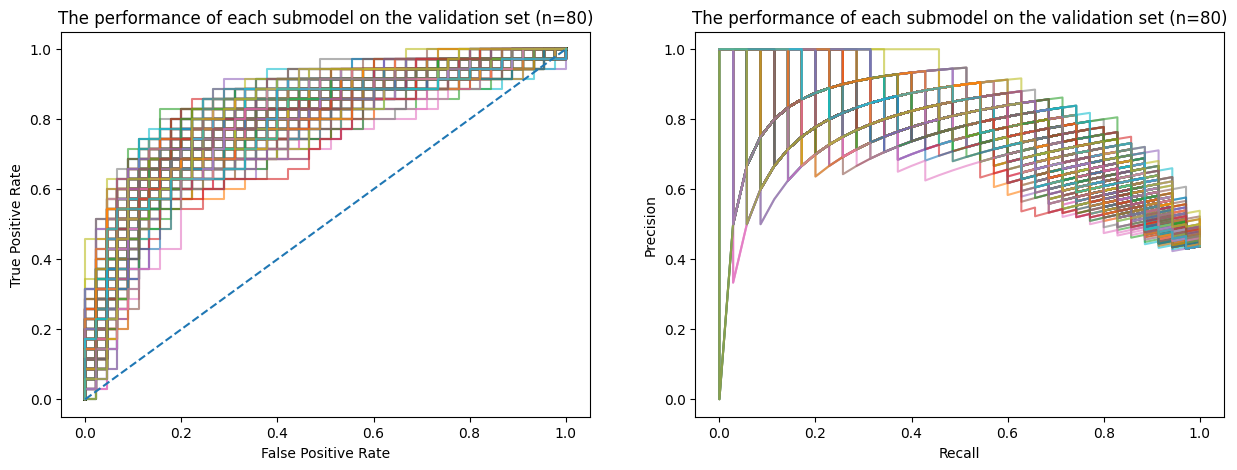

In [96]:
fig1, ax = plt.subplots(1, 2, figsize=(15, 5))

y_val_class = (y_val >= gcb_threshold).astype(int)


roc_aucs = []
pr_aucs = []
f1s = []
precisions = []
recalls = []
specificities = []

for i in range(n_models):
    y_pred_val_i = all_preds[:, i]

    y_pred_val_class_i = (y_pred_val_i >= gcb_threshold).astype(int)

    # Confusion matrix
    cm_i = confusion_matrix(y_val_class, y_pred_val_class_i)
    tn_i, fp_i, fn_i, tp_i = cm_i.ravel()
    specificities.append(tn_i / (tn_i + fp_i))

    precisions.append(precision_score(y_val_class, y_pred_val_class_i))
    recalls.append(recall_score(y_val_class, y_pred_val_class_i))
    f1s.append(f1_score(y_val_class, y_pred_val_class_i))

    # ROC and AUC
    # For ROC, we should use the raw prediction values (or probabilities in classification models).
    # Here, using continuous predictions from ElasticNet:
    fpr, tpr, _ = roc_curve(y_val_class, y_pred_val_i)
    roc_aucs.append(auc(fpr, tpr))

    # Precision-Recall curve
    precision_vals, recall_vals, pr_thresholds = precision_recall_curve(
        y_val_class, y_pred_val_i
    )
    pr_aucs.append(average_precision_score(y_val_class, y_pred_val_i))

    # Plot 1: ROC
    ax[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", alpha=0.6)
    # Plot 2: Precision-Recall
    ax[1].plot(recall_vals, precision_vals, label=f"AP = {pr_auc:.2f}", alpha=0.6)

ax[0].plot([0, 1], [0, 1], linestyle="--")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("The performance of each submodel on the validation set (n=80)")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("The performance of each submodel on the validation set (n=80)")

plt.show()

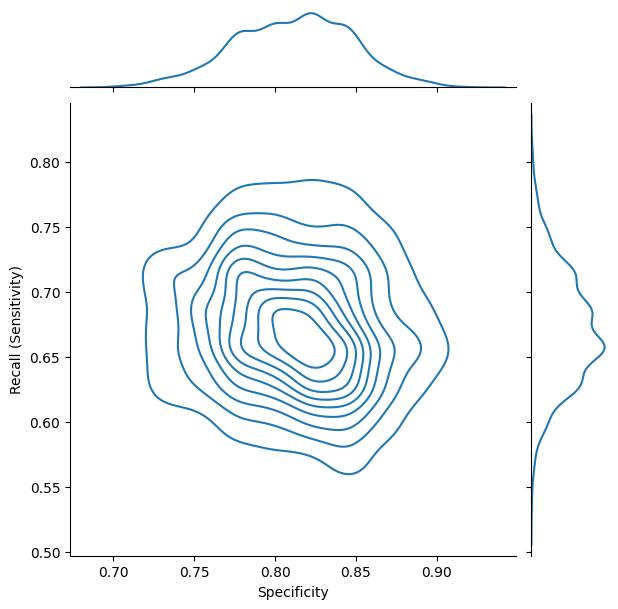

In [97]:
p = sns.jointplot(x=specificities, y=recalls, kind="kde")
p.set_axis_labels("Specificity", "Recall (Sensitivity)")

Text(0.5, 1.0, 'The distribution of Average Precision on the validation set (n=80)')

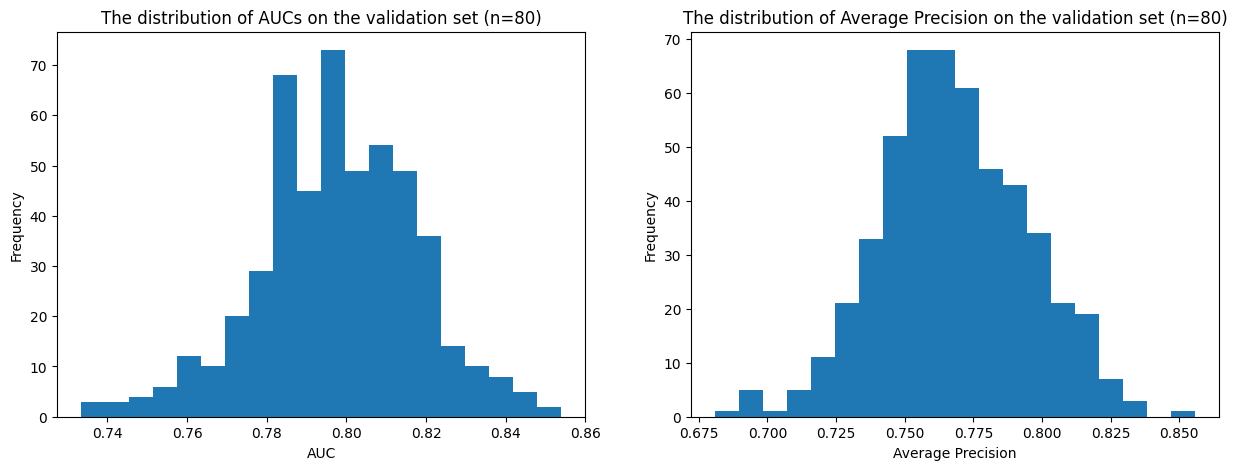

In [98]:
fig1, ax = plt.subplots(1, 2, figsize=(15, 5))


ax[0].hist(roc_aucs, bins=20)
ax[0].set_xlabel("AUC")
ax[0].set_ylabel("Frequency")
ax[0].set_title("The distribution of AUCs on the validation set (n=80)")

ax[1].hist(pr_aucs, bins=20)
ax[1].set_xlabel("Average Precision")
ax[1].set_ylabel("Frequency")
ax[1].set_title("The distribution of Average Precision on the validation set (n=80)")

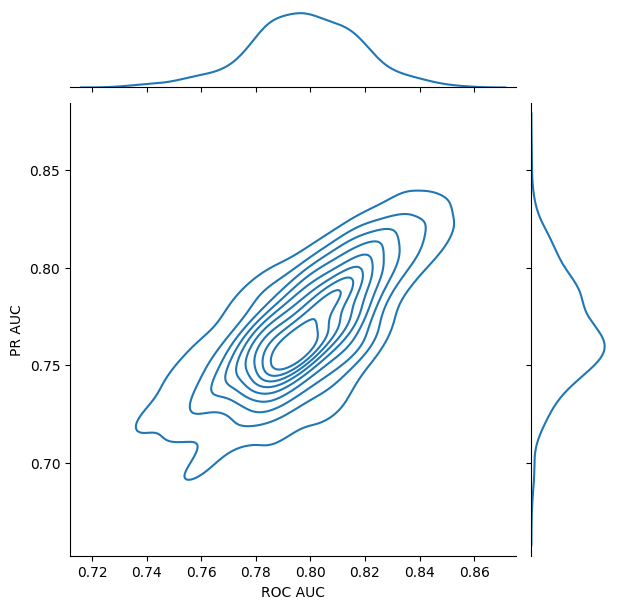

In [99]:
# Joint plot for AUCs
p = sns.jointplot(x=roc_aucs, y=pr_aucs, kind="kde")
p.set_axis_labels("ROC AUC", "PR AUC")

Seems like, there are a subset of models that perfrom better than the others. 